# Aufgabe 4.2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=200)

### Aufgabe 4.2.1 - 4.2.3

Zelle, Mesh und Solver sowie RBen

Der Solver kümmert sich automatisch zwischen den Übergang zwischen den Platten - kappa ist stückweise definiert und die Breite der Zellen ist in den Zellen enthalten

In [2]:
class cell:
    normals = np.array([(0, 1, 0), (1, 0, 0), (0, -1, 0), (-1, 0, 0), (0, 0, -1), (0, 0, 1)])
    
    def __init__(self, position, dimensions):
        self.position = np.array(position)
        self.dimensions = np.array(dimensions)
        # N, E, S, W, V, H
        areas = [(np.abs(n) - 1)* dimensions for n in self.normals]
        self.areas = [(1 if i[0] == 0 else i[0]) * (1 if i[1] == 0 else i[1]) * (1 if i[2] == 0 else i[2]) for i in areas]
class equidistant1DMesh:
    def __init__(self, width, dimensions, start_x):
        delta_x, delta_y, delta_z = dimensions
        n_x = int(width / delta_x)
        cells = []
        for x in np.linspace(start_x, width + start_x, n_x, endpoint=False):
            center = x + delta_x / 2
            newcell = cell((center, 0, 0), dimensions)
            #print(newcell.position)
            cells += [newcell]
        self.cells = cells
        self.length = len(self.cells)
    def join(self, other):
        self.cells += other.cells
        self.length = len(self.cells)
    def getLeft(self, n):
        return n-1
    def hasLeft(self, n):
        return n != 0
    def getRight(self, n):
        return n+1
    def hasRight(self, n):
        return n != len(self.cells) - 1
class solver:
    def __init__(self, mesh):
        self.mesh = mesh
    def assemble(self, kappa):
        self.A = np.zeros((self.mesh.length, self.mesh.length))
        self.rhs = np.zeros((self.mesh.length))
        for i in range(self.mesh.length):
            if self.mesh.hasLeft(i) and self.mesh.hasRight(i):
                delta_x_w = (self.mesh.cells[i].position - self.mesh.cells[self.mesh.getLeft(i)].position)[0]
                delta_x_e = (self.mesh.cells[self.mesh.getRight(i)].position - self.mesh.cells[i].position)[0]
                k_w = kappa(self.mesh.cells[i].position[0] - delta_x_w / 2)
                k_e = kappa(self.mesh.cells[i].position[0] + delta_x_e / 2)
                A_w = self.mesh.cells[i].areas[3]
                A_e = self.mesh.cells[i].areas[1]
                n_w = cell.normals[3][0]
                n_e = cell.normals[1][0]
                self.A[i, self.mesh.getLeft(i)] += - k_w * A_w * n_w / delta_x_w
                self.A[i, i] += k_w * A_w * n_w / delta_x_w - k_e * A_e * n_e / delta_x_e
                self.A[i, self.mesh.getRight(i)] += k_e * A_e * n_e / delta_x_e
    def solve(self, rbs):
        for rb in rbs:
            rb.apply(self.A, self.rhs)
        return np.linalg.solve(self.A, self.rhs)
class rb():
    position = 10
    def __init__(self, position):
        self.position = position
    def apply(self, systemmatrix, rhs):
        pass
class neumann(rb):
    waermestrom = 5
    def __init__(self, position, waermestrom, delta_x):
        super(neumann,self).__init__(position)
        self.waermestrom = waermestrom
        self.delta_x = delta_x
    def apply(self, systemmatrix, rhs):
        if (self.position == 0):
            # Vorwärtsdifferenz
            systemmatrix[self.position, 0:2] = (1, -1)
        elif (self.position < len(rhs)):
            # Rückwärtsdifferenz
            systemmatrix[self.position, self.position-1:self.position+1] = (-1, 1)
        else:
            raise ValueError("Out of bounds")
        rhs[self.position] = rhs[self.position] + self.waermestrom * self.delta_x
class dirichlet(rb):
    temperatur = 5
    def __init__(self, position, temperatur):
        super(dirichlet,self).__init__(position)
        self.temperatur = temperatur
    def apply(self, systemmatrix, rhs):
        if (self.position > len(rhs)):
            raise ValueError("Out of bounds")
        systemmatrix[self.position, self.position] = 1
        rhs[self.position] = rhs[self.position] + self.temperatur

### Aufgabe 4.2.4

In [3]:
delta_x1 = 0.1
delta_x2 = 0.02
delta_y = 0.6
delta_z = 0.7
width_1 = 0.8
width_2 = 0.2

In [4]:
m = equidistant1DMesh(width_1, (delta_x1, delta_y, delta_z), 0)
m2 = equidistant1DMesh(width_2, (delta_x2, delta_y, delta_z), width_1)
m.join(m2)

In [5]:
s = solver(m)
kappa1 = 20
kappa2 = 10
def kappa(x):
    if x <= width_1:
        return kappa1
    else:
        return kappa2
s.assemble(kappa)
rb1 = dirichlet(0, 300)
rb2 = neumann(m.length - 1, -50, delta_x2)
result = s.solve([rb1, rb2])

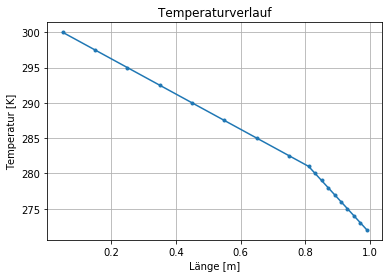

In [6]:
plt.plot([i.position[0] for i in m.cells], result, ".-")
plt.grid()
plt.title("Temperaturverlauf")
plt.ylabel("Temperatur [K]")
plt.xlabel("Länge [m]")
plt.show()